# Preprocessing Overview - Mouse Bladder
#### Input dataset: dataset/Mouse_bladder_data.h5
This HDF5 file provides the raw count matrix X, cell names, gene names, and cell‑type labels (Y). The goal of this notebook is to clean, normalize, and feature‑select the data, then compute a low‑dimensional embedding and save a standardized .h5ad for downstream clustering (KMeans, DEC, scDCC).

1. Imports & Data Loading
2. Build AnnData Object
3. Visual QC (Quick Inspection)
4. QC Filtering & Thresholds
5. Normalization & Log Transform
6. Highly Variable Genes (HVGs) + Forced Markers
7. Dimensionality Reduction & Embedding
8. Cell Count
9. Save Preprocessed Object

Overview: This notebook cleans the Mouse Bladder dataset, normalizes counts, selects informative genes (with biologically important markers), and prepares a compact, well‑behaved representation (PCA/UMAP) saved as an .h5ad. It’s the common, reproducible preprocessing stage feeding your modeling notebook.

## 1. Imports & Data Loading:
* Loads all required Python packages for handling single-cell data (scanpy, anndata, h5py), numerical processing (numpy, pandas), clustering/metrics (sklearn), deep learning (torch), and plotting (matplotlib, seaborn).
* The code opens the Mouse_bladder_data.h5 file using h5py.File and reads in the dataset components: X, which contains the gene expression matrix (cells × genes) in raw counts; cell_name, which stores the list of cell identifiers; gene_name, which stores the list of gene identifiers; and Y, which contains the cell type labels. Since some of these values may be stored as byte strings in the HDF5 file, the code converts them into standard Python strings when necessary. It also ensures that the cell type labels are handled correctly—if stored as text, they are decoded into strings, and if stored in numeric format, they are kept as numbers.

In [1]:
# -------- Imports and Setup --------
import scanpy as sc
import os
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment
import random
from itertools import combinations, product
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import anndata as ad
import pandas as pd

# ---------- Load raw Mouse Bladder dataset (.h5) ---------
# The file stores:
#   - X: raw count matrix (cells x genes)
#   - cell_name: per-cell identifiers
#   - gene_name: per-gene identifiers
#   - Y: cell-type labels (string or numeric)
with h5py.File("dataset/Mouse_bladder_data.h5", "r") as f:
    X = f["X"][:] # Expression counts (dense array)

    # Decode identifiers; HDF5 may store as bytes -> convert to str
    cell_names = f["cell_name"][:].astype(str)
    gene_names = f["gene_name"][:].astype(str)

    # Labels can be stored as bytes (S) / object (O) or numeric; handle both
    if f["Y"].dtype.kind in {"S", "O"}:
        labels = f["Y"][:].astype(str)
    else:
        labels = f["Y"][:]

## 2. Build AnnData Object:
This code creates an AnnData object, which is a common data structure used in Scanpy for storing and processing single-cell RNA-seq data.
We load the expression matrix X along with cell metadata (names and cell type labels) and gene metadata (gene names) into the obs and var attributes, respectively.
We then set the observation (obs_names) and variable (var_names) indices explicitly to ensure correct alignment during analysis. Finally, we print a summary of the AnnData object and preview the first few rows of cell metadata.

In [2]:
# Create an AnnData object to store the single-cell RNA-seq data
adata = ad.AnnData(
    X=X, # Expression matrix (cells × genes)

    # Metadata for observations (cells)
    obs=pd.DataFrame({"cell_name": cell_names, "cell_type": labels}, index=cell_names),

    # Metadata for variables (genes)
    var=pd.DataFrame({"gene_name": gene_names}, index=gene_names)
)

# Explicitly set variable and observation names (for consistency in downstream processing)
adata.var_names = gene_names
adata.obs_names = cell_names

print(adata)
adata.obs.head()

AnnData object with n_obs × n_vars = 2746 × 20670
    obs: 'cell_name', 'cell_type'
    var: 'gene_name'


,cell_name,cell_type
Bladder_1.AAAACGAAAACGGGGCGA,Bladder_1.AAAACGAAAACGGGGCGA,1
Bladder_1.AAAACGAAGCGGCCGCTA,Bladder_1.AAAACGAAGCGGCCGCTA,5
Bladder_1.AAAACGAAGTACTAGCAT,Bladder_1.AAAACGAAGTACTAGCAT,16
Bladder_1.AAAACGACGTTGCTGTGT,Bladder_1.AAAACGACGTTGCTGTGT,8
Bladder_1.AAAACGAGCGAGCGAGTA,Bladder_1.AAAACGAGCGAGCGAGTA,4


## 3. Visual QC

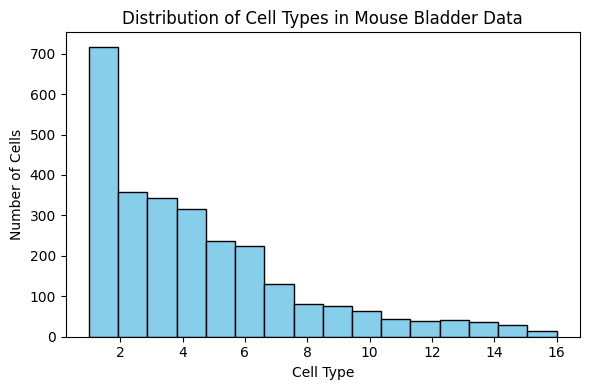

In [3]:
plt.figure(figsize=(6,4))
plt.hist(adata.obs['cell_type'], bins=len(np.unique(adata.obs['cell_type'])), color='skyblue', edgecolor='k')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.title('Distribution of Cell Types in Mouse Bladder Data')
plt.tight_layout()
plt.show()

## 4. QC Filtering & Thresholds:
This section is performing quality control on the single-cell RNA-seq dataset:
* Filters low-quality cells (low gene counts, high mitochondrial content).
* Removes rare genes detected in too few cells.
* Uses QC plots to visually assess filtering thresholds.
* Removes outliers to ensure only high-quality cells remain for analysis.

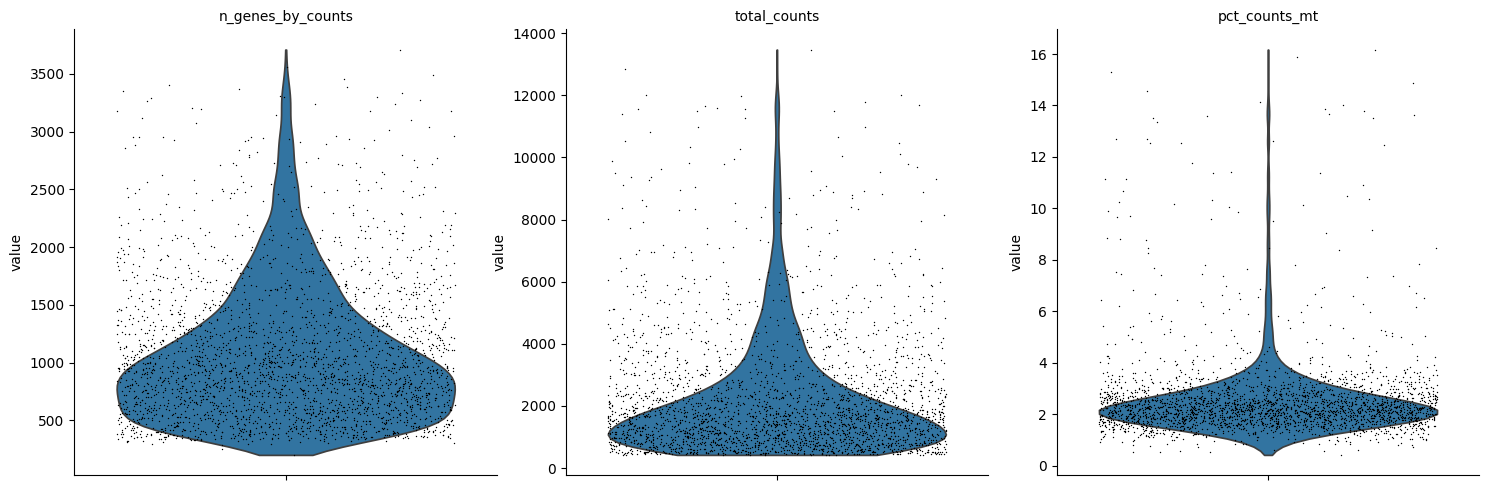

In [4]:
# --- Basic filtering ---
# Keep cells that have at least 200 detected genes
sc.pp.filter_cells(adata, min_genes=200)

# Keep genes that are detected in at least 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# --- Identify mitochondrial genes ---
# Create a boolean mask for mitochondrial genes (gene names start with 'MT-')
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

# Calculate quality control (QC) metrics
# qc_vars=['mt'] ensures mitochondrial gene percentages are included
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# --- Visualize QC metrics ---
# Violin plots showing:
# - Number of genes detected per cell (n_genes_by_counts)
# - Total counts per cell (total_counts)
# - Percentage of mitochondrial counts (pct_counts_mt)
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)
plt.show()

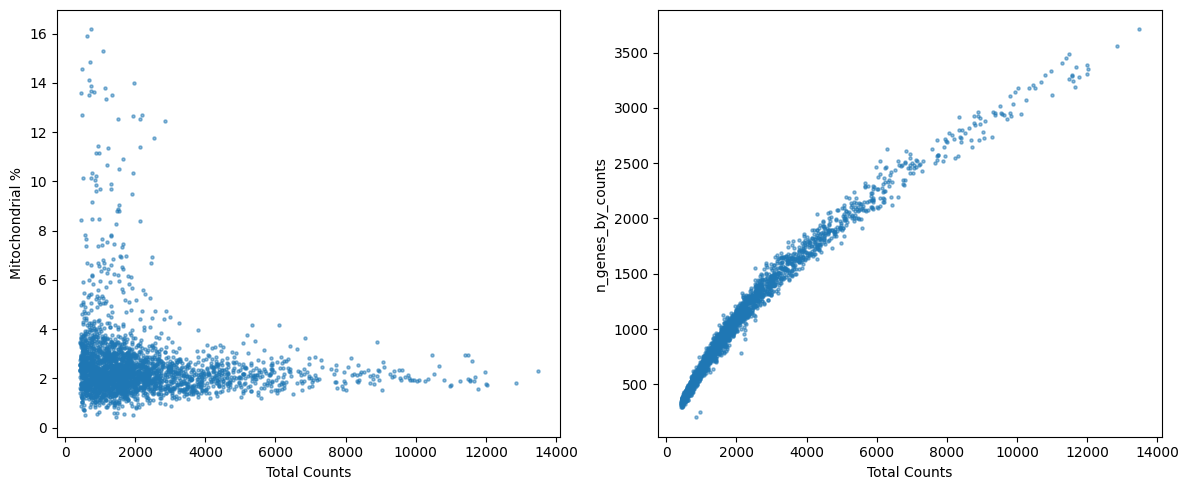

In [5]:
# Scatter plots to explore relationships between QC metrics
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Total counts vs mitochondrial percentage
axs[0].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], s=5, alpha=0.5)
axs[0].set_xlabel('Total Counts'); axs[0].set_ylabel('Mitochondrial %')

# Total counts vs number of genes detected
axs[1].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], s=5, alpha=0.5)
axs[1].set_xlabel('Total Counts'); axs[1].set_ylabel('n_genes_by_counts')
plt.tight_layout()
plt.show()

# --- Filter out low-quality cells ---
# Remove cells with >4% mitochondrial gene expression (high mt% suggests stressed/dying cells)
adata = adata[adata.obs['pct_counts_mt'] < 4, :]

# Determine cutoffs for unusually high counts or genes (remove outliers)
gene_cutoff = np.percentile(adata.obs['n_genes_by_counts'], 99)
count_cutoff = np.percentile(adata.obs['total_counts'], 99)

# Apply cutoffs
adata = adata[adata.obs['n_genes_by_counts'] < gene_cutoff, :]
adata = adata[adata.obs['total_counts'] < count_cutoff, :]

/tmp/ipython-input-1784738465.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()


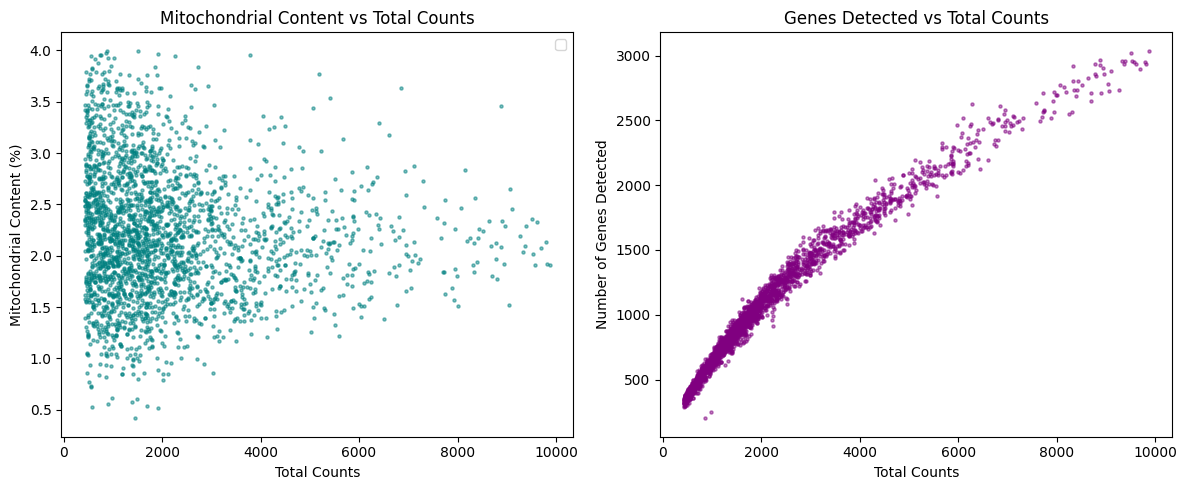

In [6]:
# --- Visualize filtered dataset ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Mitochondrial content vs total counts
axs[0].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], s=5, alpha=0.5, color='teal')
axs[0].set_xlabel('Total Counts')
axs[0].set_ylabel('Mitochondrial Content (%)')
axs[0].set_title('Mitochondrial Content vs Total Counts')
axs[0].legend()

# Number of genes detected vs total counts
axs[1].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], s=5, alpha=0.5, color='purple')
axs[1].set_xlabel('Total Counts')
axs[1].set_ylabel('Number of Genes Detected')
axs[1].set_title('Genes Detected vs Total Counts')

plt.tight_layout()
plt.show()

## 5. Normalization & Log Transform:
This step scales and stabilizes the data before feature selection and clustering. Without this, cells with more reads or extremely high gene counts could dominate the analysis.

In [7]:
# --- Normalize the data ---
# Normalize total counts per cell so that each cell has the same total count (target_sum = 10,000)
# This ensures comparability between cells by removing sequencing depth bias
sc.pp.normalize_total(adata, target_sum=1e4)

# --- Log-transform the data ---
# Apply log(x + 1) transformation to reduce the impact of highly expressed genes
# This makes the data more normally distributed and suitable for downstream analysis
sc.pp.log1p(adata)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## 6. Highly Variable Genes (HVGs) + Forced Markers:
In this step, we identify the most informative genes for downstream analysis by selecting the top 2000 highly variable genes (HVGs) using the Seurat method. Since some biologically important bladder cell marker genes might not appear in this HVG list, we manually force-include them to ensure critical cell type information is preserved. The dataset is then subset to include only HVGs and these marker genes, and the resulting subset is re-normalized and log-transformed to prepare it for clustering and other analyses.

In [8]:
# --- Identify Highly Variable Genes (HVGs) ---
# Use the Seurat method to select the top 2000 highly variable genes across cells
# HVGs are more informative for clustering than low-variance genes
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, subset=False)

# --- Define biologically important genes to force-include ---
# Even if they are not in the top 2000 HVGs, we want to ensure certain known marker genes
# for specific bladder cell types are kept for downstream analysis
force_genes = [
    'Upk1a', 'Upk1b', 'Upk2', 'Upk3a', 'Krt20',  # Umbrella cells
    'Krt8', 'Krt18', 'Sprr2f',                   # Intermediate cells
    'Krt5', 'Krt14', 'Krt15', 'Trp63', 'Shh',    # Basal cells
    'Col1a1', 'Col3a1', 'Dcn',                   # Fibroblasts
    'Acta2', 'Myh11',                            # Smooth muscle
    'Pecam1', 'Cdh5',                            # Endothelial
    'Adgre1', 'Cd68',                            # Macrophages
    'Cd3d', 'Cd3e', 'Cd4', 'Cd8a',               # T cells
    'Cd19', 'Ms4a1',                             # B cells
    'Itgax', 'Flt3',                             # Dendritic cells
    'Nkg7', 'Klrd1',                             # NK cells
    'Kit', 'Mcpt4',                              # Mast cells
    'Tubb3', 'Snap25',                           # Neurons
    'Ascl1', 'Plxna4'                            # Urothelial progenitors
]

# --- Ensure force-included genes are marked as HVGs ---
hvg_mask = adata.var['highly_variable'].copy()
for g in force_genes:
    if g in adata.var_names: # Check if gene exists in dataset
        hvg_mask[adata.var_names.get_loc(g)] = True

# --- Subset AnnData to only HVGs + forced marker genes ---
adata_hvg = adata[:, hvg_mask].copy()

# Save the original expression values of HVGs for later use
adata_hvg.raw = adata[:, hvg_mask].copy()

# --- Re-normalize and log-transform after HVG selection ---
# Ensures the reduced dataset is scaled and ready for analysis
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)

/tmp/ipython-input-3546271212.py:30: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  hvg_mask[adata.var_names.get_loc(g)] = True


## 7. Dimensionality Reduction & Embedding:
This section reduces the dataset’s dimensionality using PCA, builds a nearest neighbors graph from the reduced space, and then applies UMAP to project the cells into 2D for easier visualization of clusters and relationships between cell types.

In [9]:
# Perform PCA (Principal Component Analysis) to reduce dimensionality to 50 components.
# This helps in capturing the most relevant variation in the dataset while removing noise.
sc.tl.pca(adata_hvg, n_comps=50)

# Compute the k-nearest neighbors graph using the top 50 PCA components.
# This step is essential for manifold learning methods like UMAP and clustering.
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=50)

# Compute a 2D UMAP (Uniform Manifold Approximation and Projection) embedding
# for visualizing the relationships between cells in a low-dimensional space.
sc.tl.umap(adata_hvg)

## 8. Cell Count:
This prints a clean summary of how many cells belong to each annotated cell_type in the preprocessed HVG subset (adata_hvg).

In [10]:
# Display the count of cells for each annotated cell type
print("\n--- Annotated Cell Type Distribution ---")
print(adata_hvg.obs['cell_type'].value_counts().to_string())


--- Annotated Cell Type Distribution ---
cell_type
1     710
2     348
3     342
4     314
5     235
6     224
8      77
9      48
7      45
13     41
11     39
12     38
14     36
15     30
16     13


## 9. Save Preprocessed Object

In [11]:
adata_hvg.write("processed_dataset/mouse_bladder_preprocessed.h5ad")